In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

from data_pipeline import load_benchmarks, preprocess_for_modeling, create_forecast_grid
from forecasting import BenchmarkForecaster

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, inflection_point, rate_mu, rate_sigma, growth_rate, alpha_mu, alpha_sigma, alpha_raw, noise_base_mu, noise_base_sigma, noise_base, skew_mu, skew_sigma, skewness]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/antoinemaier/Documents/Semaphore/benchmark-forecasting/data_pipeline.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_generate_benchmark_grid)
Sampling: []


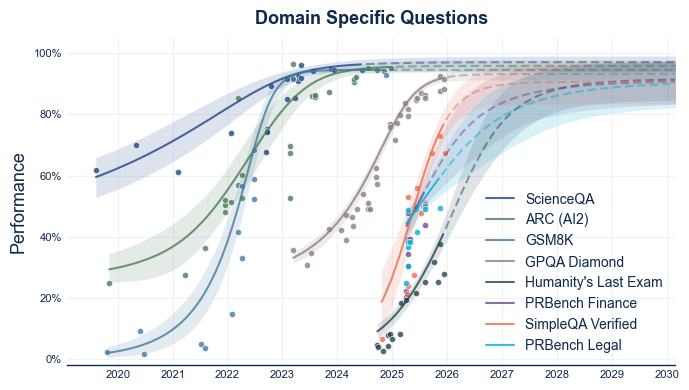

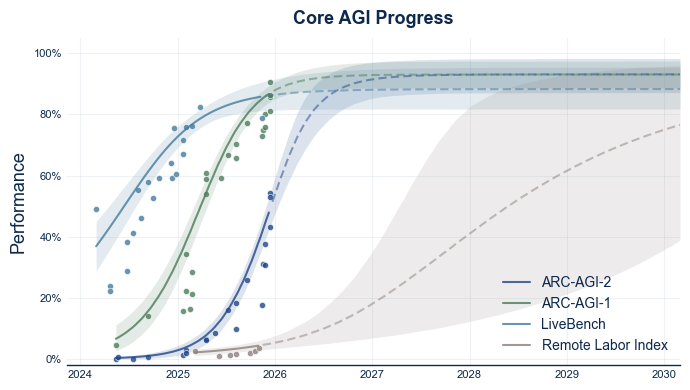

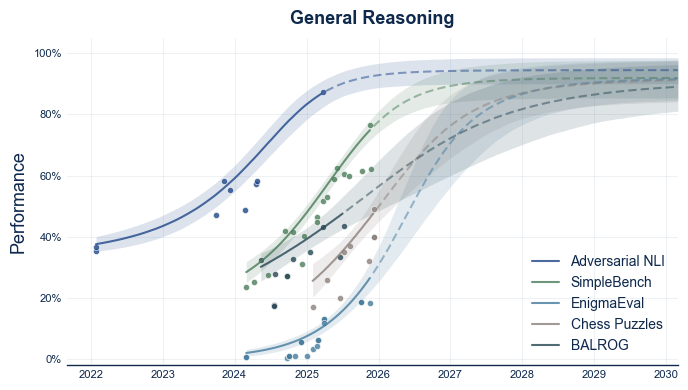

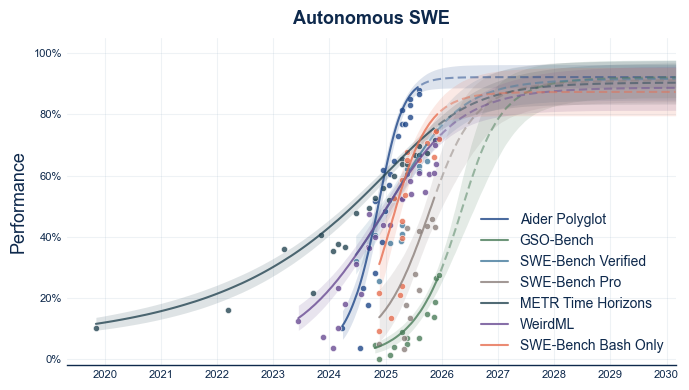

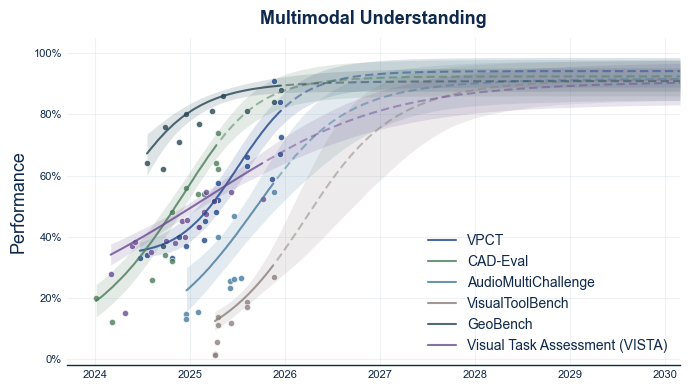

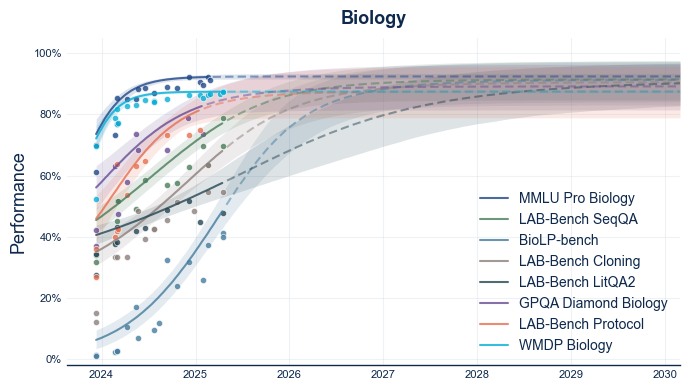

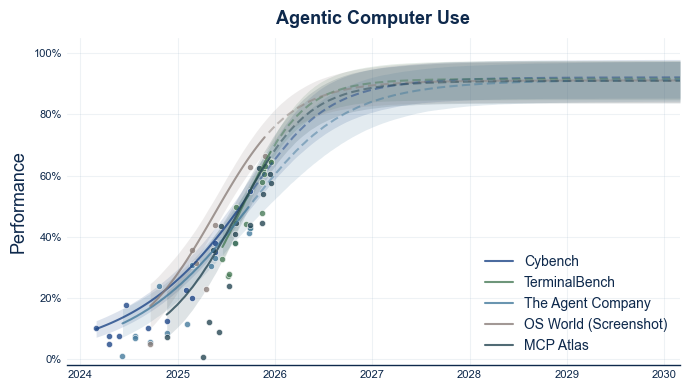

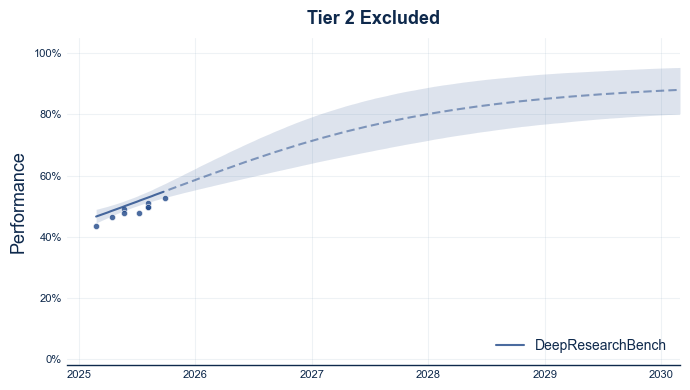

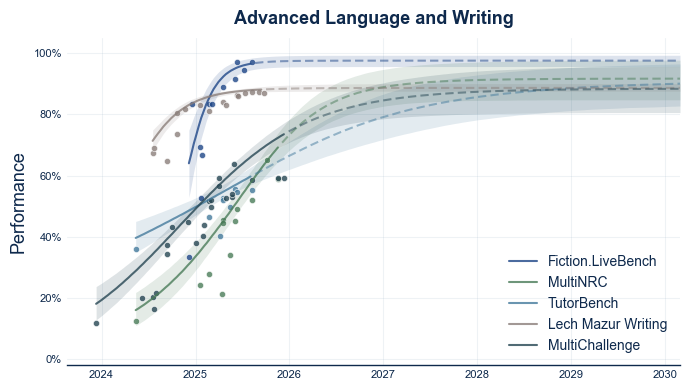

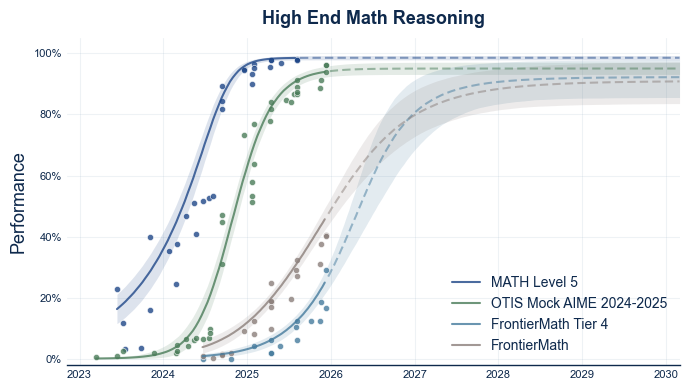

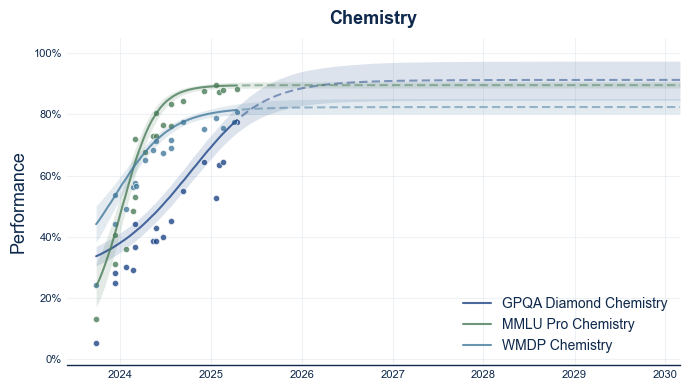

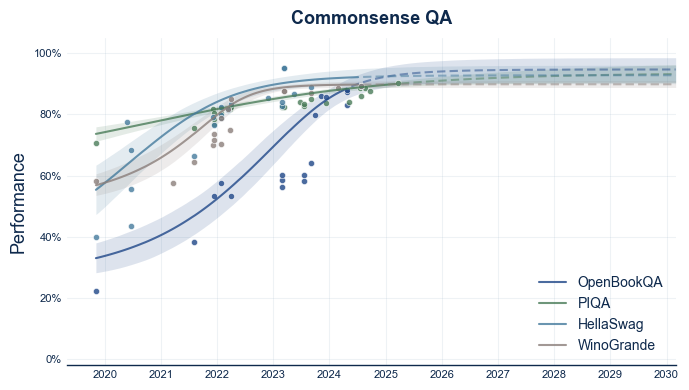

In [ ]:
# --- Configuration ---
FRONTIER_DEPTH = 3
GROWTH_FUNCTION = "harvey"
HIERARCHICAL = True
FORECAST_END_DATE = pd.to_datetime("2030-03-01")
CI_WIDTH = 0.8
FORECAST_PERIODS = 200

STYLE_CONFIG = {
    "font_family": ["Arial", "Helvetica"],
    "base_color": "#0e294c",
    "grid_color": "#5F86A5",
    "plot_colors": [
        "#1f4788",
        "#4a7c59",
        "#457b9d",
        "#8b7f7b",
        "#264653",
        "#6a4c93",
        "#e76f51",
        "#06aed5",
        "#f4a261",
        "#2a9d8f",
    ],
}

# --- Setup ---
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": STYLE_CONFIG["font_family"],
        "axes.facecolor": "none",
        "figure.facecolor": "none",
        "grid.alpha": 0.2,
    }
)

# --- Pipeline Execution ---

# 1. Data Loading & Preprocessing
dataset = load_benchmarks()
train_df = preprocess_for_modeling(dataset, top_n_frontier=FRONTIER_DEPTH)

# 2. Model Fitting
forecaster = BenchmarkForecaster(
    growth_function=GROWTH_FUNCTION, hierarchical=HIERARCHICAL, frontier_depth=FRONTIER_DEPTH
)
forecaster.fit(train_df, show_progress=True)

# 3. Forecasting
grid_df = create_forecast_grid(
    train_df, cutoff_date=FORECAST_END_DATE, periods=FORECAST_PERIODS
)

all_forecasts = forecaster.predict(grid_df, ci_width=CI_WIDTH)

# --- Visualization ---

# Handle case where category might be missing, default to single group
categories = train_df["category"].unique() if "category" in train_df else [None]

for category in categories:
    # Filter Data
    if category:
        subset_obs = train_df[train_df["category"] == category]
        subset_pred = all_forecasts[all_forecasts["category"] == category]
        title = category
    else:
        subset_obs = train_df
        subset_pred = all_forecasts
        title = "All Benchmarks"

    # Sort benchmarks by final predicted mean for visual consistency in legend
    final_perfs = subset_pred.loc[
        subset_pred["release_date"] == subset_pred["release_date"].max()
    ].set_index("benchmark")["mean_pred"]

    sorted_benchmarks = final_perfs.sort_values(ascending=False).index.tolist()

    fig, ax = plt.subplots(figsize=(7, 4))

    for benchmark, color in zip(
        sorted_benchmarks, itertools.cycle(STYLE_CONFIG["plot_colors"])
    ):
        bench_obs = subset_obs[subset_obs["benchmark"] == benchmark]
        bench_pred = subset_pred[subset_pred["benchmark"] == benchmark]

        if bench_obs.empty:
            continue

        # Plot Observations
        ax.scatter(
            bench_obs["release_date"],
            bench_obs["score"],
            color=color,
            s=20,
            alpha=0.8,
            edgecolor="white",
            linewidth=0.5,
            zorder=5,
        )

        # Plot Forecast (History vs Future)
        last_obs_date = bench_obs["release_date"].max()

        # Solid line (History)
        hist_mask = bench_pred["release_date"] <= last_obs_date
        ax.plot(
            bench_pred.loc[hist_mask, "release_date"],
            bench_pred.loc[hist_mask, "mean_pred"],
            linewidth=1.5,
            color=color,
            alpha=0.8,
            label=benchmark,
            zorder=6,
        )

        # Dashed line (Future) - Start from last obs to ensure continuity
        future_mask = bench_pred["release_date"] >= last_obs_date
        ax.plot(
            bench_pred.loc[future_mask, "release_date"],
            bench_pred.loc[future_mask, "mean_pred"],
            linewidth=1.5,
            color=color,
            alpha=0.5,
            linestyle=(5, (4, 2)),
            zorder=6,
        )

        # Uncertainty Band
        ax.fill_between(
            bench_pred["release_date"],
            bench_pred["lower_ci"],
            bench_pred["upper_ci"],
            color=color,
            alpha=0.15,
            linewidth=0,
            zorder=4,
        )

    # Formatting
    ax.set_xlim(right=FORECAST_END_DATE)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel("", fontsize=13, color=STYLE_CONFIG["base_color"])

    ax.set_ylim(-0.02, 1.05)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))
    ax.set_ylabel(
        "Performance",
        fontsize=13,
        fontweight="500",
        color=STYLE_CONFIG["base_color"],
    )

    ax.grid(True, alpha=0.1, linewidth=0.8, color=STYLE_CONFIG["grid_color"])
    sns.despine(ax=ax, top=True, right=True, left=True)
    ax.spines["bottom"].set_color(STYLE_CONFIG["base_color"])
    ax.tick_params(axis="y", left=False, right=False)
    ax.tick_params(labelsize=8, colors=STYLE_CONFIG["base_color"])

    legend = ax.legend(
        loc="lower right",
        fontsize=10,
        framealpha=0.95,
        edgecolor=STYLE_CONFIG["base_color"],
        fancybox=True,
        ncol=1,
    )
    for text in legend.get_texts():
        text.set_color(STYLE_CONFIG["base_color"])

    ax.set_title(
        title, fontsize=13, fontweight="600", color=STYLE_CONFIG["base_color"], pad=10
    )

    plt.tight_layout()
    plt.show()